## Processing PPG Signal I Recorded on My Smartphone

In [1]:
import numpy
import matplotlib.pyplot as plt
import os
fps = 30.323427803

Here we refer to the time window as the frame. Each frame is 0.033 sec front and back (so 0.67 total)

First we create a class called RRIT (RR interval). It contains one rr interval value and its corresponding time in a signal

In [2]:
class RRIT:
    def __init__(self, time, value):
        self.value = value
        self.time = time
    def __str__(self):
        return '{0:<6.2f} {1:<4}'.format(self.time, self.value)

Next, we define a class called RRSignal extending list that holds many RRITS. That is, it is a special list of RRIT. The object of this class is supposed to record all the information known about the signal.

For alignment, there are 3 main functions: interpolate and align. 

"Interpolate" takes in a time, and returns the mapped RR value on this signal.

"Align" takes in two signal, one from ecg and one from ppg, and interpolates each RRIT from the ppg onto the ecg. It returns a total alignment distance.

"AlignMultiple" builds upon "align" and align a ppg's RRIT signal with multiple ecg, and return the one with minimal alignment distance, that is, the ecg signal the ppg mostly likely to be originated from.

In [3]:
def withinRange(begin, endExclude, value):
    return begin <= value and value < endExclude

class RRSignal(list):
    def __init__(self, rrValueList, name, color=None, threshold=None, percentError=None):
        list.__init__(self)
        self.constructRRITList(rrValueList)
        self.name = name
        self.color = color
        self.threshold = threshold
        self.percentError = percentError
    def getRRITList(self):
        return [RRIT.value for RRIT in self]
    def getTimeList(self):
        return [RRIT.time for RRIT in self]
    def duration(self, beginIndex=-1, endIndex=-1):
        beginT = self[beginIndex].time if withinRange(0, len(self), beginIndex) else self[0].time
        endT = self[endIndex-1].time if withinRange(0, len(self), endIndex-1) else self[-1].time
        return endT - beginT
    #this function is only used internally
    #create a corresponding RRIT list from the rr value list
    #rr value in ms; time in second
    def constructRRITList(self, rrValueList):
        firstRRValue = round(rrValueList[0]*1000)
        self.append(RRIT(0, firstRRValue))
        pastTime = 0
        for i in range(1, len(rrValueList)):
            curTime = pastTime + rrValueList[i-1]
            curRRValue = round(rrValueList[i]*1000)
            curRRIT = RRIT(curTime, curRRValue)
            self.append(curRRIT)
            pastTime = curTime
    def interpolate(self, targetTime, indexOffset=0):
        targetTime = self[indexOffset].time + targetTime
        #targetTime is not in range of array
        if targetTime < self[0].time or self[-1].time < targetTime:
            return -1
        #if targetTime is in range, locate its position on this set
        leftIndex = -1
        for i in range(len(self)):
            if targetTime < self[i].time:
                leftIndex = i-1
                break
        leftRRIT = self[leftIndex]
        rightRRIT = self[leftIndex+1]
        slope = (rightRRIT.value - leftRRIT.value) / (rightRRIT.time - leftRRIT.time)
        deltaTime = targetTime - leftRRIT.time
        deltaValue = deltaTime * slope
        return leftRRIT.value + deltaValue
    def align(ppg, ecg):
        minAlignmentDistance = 100000000
        bestFitTime = None
        for i in range(len(ecg)):
            if ppg.duration() > ecg.duration(beginIndex=i):
                break
            alignmentDistance = 0
            for ppgRRIT in ppg:
                interpolatedValue = ecg.interpolate(ppgRRIT.time, indexOffset=i)
                alignmentDistance += abs(interpolatedValue - ppgRRIT.value)
            if alignmentDistance < minAlignmentDistance:
                minAlignmentDistance = alignmentDistance
                bestFitTime = ecg[i].time
        return bestFitTime, minAlignmentDistance
    def alignMultiple(ppg, *ecgSignalList):
        minAlignmentDistance = 1000000
        bestFitTime = None
        bestFitEcg = None
        for ecg in ecgSignalList:
            alignmentTime, alignmentDistance = RRSignal.align(ppg, ecg)
            if alignmentDistance < minAlignmentDistance:
                minAlignmentDistance = alignmentDistance
                bestFitTime = alignmentTime
                bestFitEcg = ecg
        return bestFitEcg, bestFitTime, minAlignmentDistance
        
        

The following functions are used in translating the rgb values of txt files to a list of RRIT. It culminates in the function "analyzeVideoAndObtainBestRedRRInterval."

In [4]:
def readFromFile(fileName):
    l =numpy.loadtxt(fileName)
    return l[0], l[1], l[2]

In [5]:
def detectPeak(colorL, frameThreshold):
    peakL = list()
    colorlistLen = len(colorL)
    for i in range(1, colorlistLen-1):
        biggerThanPrevious = colorL[i] > colorL[i-1]
        biggerThanAfter = colorL[i] > colorL[i+1]
        #if it is a local maximum, then check if it is a RR peak by comparing its maxima interval to frameThreshold
        if biggerThanPrevious and biggerThanAfter:
            for k in range(2, frameThreshold+1):
                if i-k >= 0:
                    if not colorL[i] > colorL[i-k]:
                        #this is not a rr peak
                        break
                if i+k < colorlistLen:
                    if not colorL[i] > colorL[i+k]:
                        #this is not a rr peak
                        break
            else:
                #this IS a rr peak, store the array index
                peakL.append(i)
    return peakL

In [6]:
def constructRRIntervalList(peakL):
    return [ (peakL[i]-peakL[i-1])/fps for i in range(1, len(peakL))]

In [7]:
def isTrueRRInterval(rrInterval):
    if 0.54 <= rrInterval and rrInterval <= 1.2:
        return True
    else:
        return False

In [8]:
def getPercentError(rrL):
    errorNum = 0
    for rrInterval in rrL:
        if not isTrueRRInterval(rrInterval):
            errorNum += 1
    return 100.0*errorNum/len(rrL) if len(rrL) else 0


In [9]:
def analyzeVideoAndObtainBestRedRRInterval(fileName):
    rErrorL = []
    rL, gL, bL = readFromFile(fileName)
    bestRRL = None
    bestPercentErrorSoFar = 101
    bestFrameThreshold = None
    lowestPercentError = None
    for frameThreshold in range(1, 26):
        rRRL = constructRRIntervalList(detectPeak(rL, frameThreshold))
        percentError = getPercentError(rRRL)
        if percentError < bestPercentErrorSoFar:
            bestPercentErrorSoFar = percentError
            bestRRL = rRRL
            bestFrameThreshold = frameThreshold*2
            lowestPercentError = percentError
    return bestRRL, lowestPercentError, bestFrameThreshold

In [10]:
def convertStrLToSecFloatL(array):
    for i in range(len(array)):
        array[i] = float(array[i])/1000.0
    return array

Here we have two ppg signal I recorded on my smartphone. I convert these two to RRSignal and graph them.

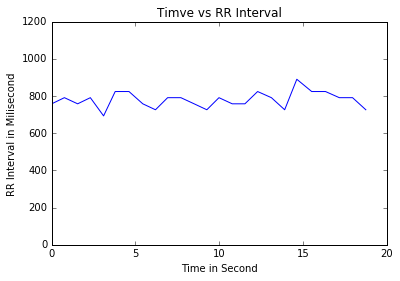

In [11]:
%matplotlib inline
vidName = "/home/mong/Desktop/map/map/videos/ccc.3gp.txt"
ppgRRSignal, percentError, threshold = analyzeVideoAndObtainBestRedRRInterval(vidName)
ppgRRSignal = RRSignal(ppgRRSignal, os.path.basename(vidName), color='red', percentError=percentError, threshold=threshold)
plt.plot(ppgRRSignal.getTimeList(), ppgRRSignal.getRRITList())
plt.xlabel('Time in Second')
plt.ylabel('RR Interval in Milisecond')
plt.title('Timve vs RR Interval')
plt.ylim(0, 1200)
plt.show()

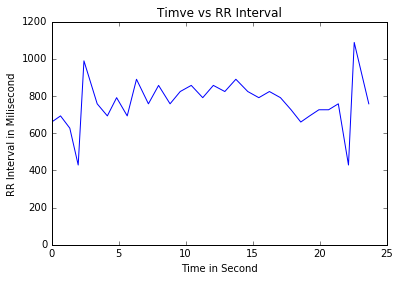

In [12]:
%matplotlib inline
vidName = "/home/mong/Desktop/map/map/videos/ddd.3gp.txt"
ppgRRSignal, percentError, threshold = analyzeVideoAndObtainBestRedRRInterval(vidName)
ppgRRSignal = RRSignal(ppgRRSignal, os.path.basename(vidName), color='red', percentError=percentError, threshold=threshold)
plt.plot(ppgRRSignal.getTimeList(), ppgRRSignal.getRRITList())
plt.xlabel('Time in Second')
plt.ylabel('RR Interval in Milisecond')
plt.title('Timve vs RR Interval')
plt.ylim(0, 1200)
plt.show()